<a href="https://colab.research.google.com/github/ArtemChemist/CFU_counter/blob/main/Evaluate_saved_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 69.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: t

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime
import time

import cv2

from keras.models import Model, Sequential
import tensorflow as tf
print(tf.__version__)


2.9.1


In [3]:
SIZE = 456 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

Filters = 16
BATCH_SIZE = 32
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

num_classes = 2  # Number of clases for prediction

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Import custom module with helper functions
import sys
sys.path.append('/content/drive/My Drive')
import funcs as f

Mounted at /content/drive


In [5]:
!unzip -q "/content/drive/My Drive/456_nothresh.zip" -d "/content"

### Read images and visualize a sample

In [6]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
input_dir = os.path.join(p)

X_files , y = f.read_names(input_dir)
print(f'Full dataset: {np.sum(y)} images with bacteria and {len(y)-np.sum(y)} without')

Full dataset: 300 images with bacteria and 3479 without


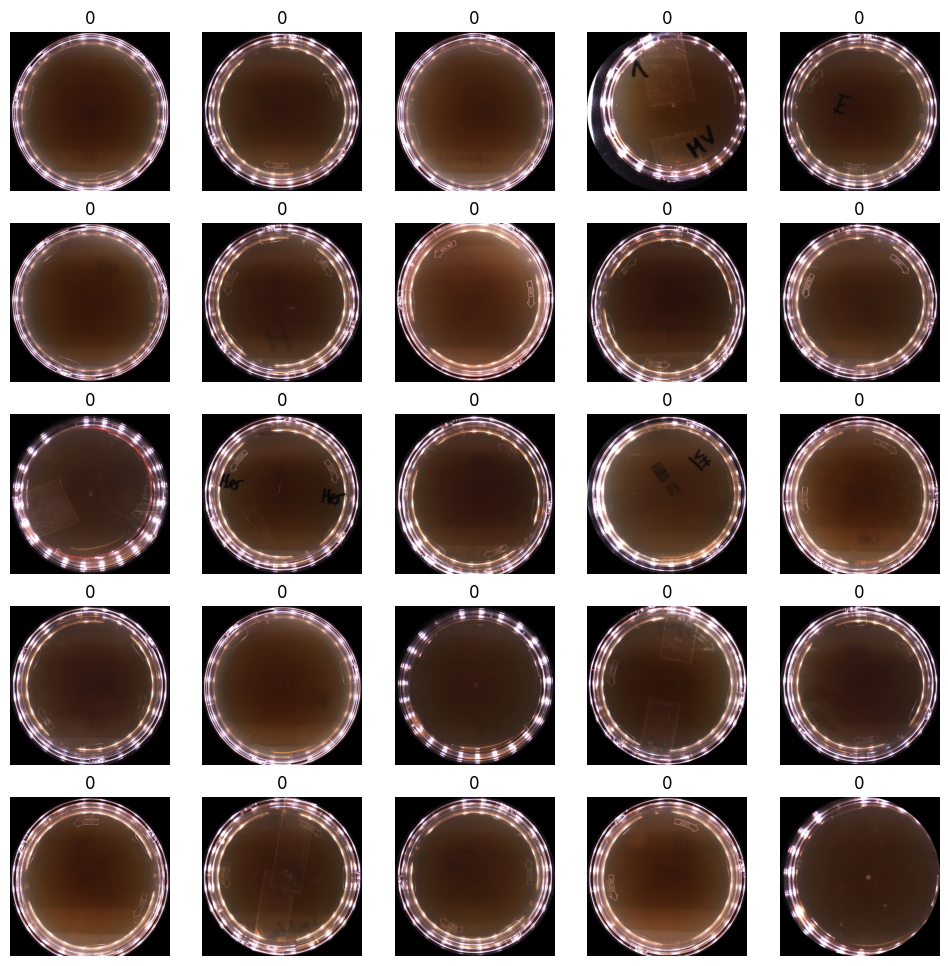

In [7]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    file = os.path.join(input_dir, X_files[idx])
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    axs[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y[idx])
    axs[i,j].axis('off')

plt.show()

In [8]:
# Get the names of the files that will be used for both thresholded and non-thresholded images
X_train_names, X_val_names, _ , y_val = f.custom_train_val_split(X_files, y, TEST_SIZE, RAND_SEED)

# Read the actual files
print("Reading images...")
X_train = f.read_images(X_train_names, input_dir)
X_val = f.read_images(X_val_names, input_dir)

# Create a TensorFlow Dataset
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from content... Done
Reading 1133 images from content... Done


In [9]:
#Load model
model_dir = os.path.join(p, "drive", "MyDrive", 'B5')
model = tf.keras.models.load_model(
    model_dir, custom_objects=None, compile=True, options=None)

In [10]:
# Save results and telemetry into a csv
result_dir = os.path.join(p, "drive", "MyDrive", 'B5_initial')
y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(X_val)
thresholds = np.arange(0, 0.055, 0.0005)

f.save_model_results(model, 'NAN', X_val_names, 0.0005, y_true, y_pred, thresholds, 'NAN', result_dir, 'B5_initial')

36/36 [==============================] - 410s 11s/step
Saving precision-recall data...
Saving names of mispredicted images...
